In [1]:
! pip install neattext


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [120]:
# importing important libraries
import numpy as np
import pandas as pd
import neattext as nt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bgaut\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Collection

In [4]:
# Dataset link:
# https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text/data?select=emotion_sentimen_dataset.csv

In [5]:
df = pd.read_csv("emotion_sentimen_dataset.csv")

In [6]:
df.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [7]:
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [8]:
df.head()

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


## Data Cleaning & Preprocessing

In [9]:
df['Emotion'].unique()

array(['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness',
       'fun', 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom'],
      dtype=object)

In [10]:
df['Emotion'].nunique()

13

In [11]:
df.shape

(839555, 2)

In [12]:
df.isnull().sum()

text       0
Emotion    0
dtype: int64

In [13]:
df.duplicated().sum()

np.int64(445733)

In [14]:
df[df['text'].duplicated()]

,text,Emotion
1930,i resorted to yesterday the post peak day of i...,neutral
4869,i feel pretty tortured because i work a job an...,neutral
5870,i feel like a tortured artist when i talk to her,neutral
6008,i feel wronged by certain people and my instin...,anger
6019,i remember then feeling bitter that i couldnt ...,neutral
...,...,...
839550,i feel like telling these horny devils to find...,neutral
839551,i began to realize that when i was feeling agi...,neutral
839552,i feel very curious be why previous early dawn...,neutral
839553,i feel that becuase of the tyranical nature of...,neutral


In [15]:
df.drop_duplicates(inplace = True)

In [16]:
df.shape

(393822, 2)

In [17]:
df.duplicated().sum()

np.int64(0)

In [18]:
df['Emotion'].value_counts()

Emotion
neutral       316935
love           17634
happiness      13038
sadness         8485
relief          8007
hate            6160
anger           5952
fun             4854
enthusiasm      4497
surprise        3430
empty           2697
worry           2072
boredom           61
Name: count, dtype: int64

Text(0.5, 1.0, 'Emotion visualization')

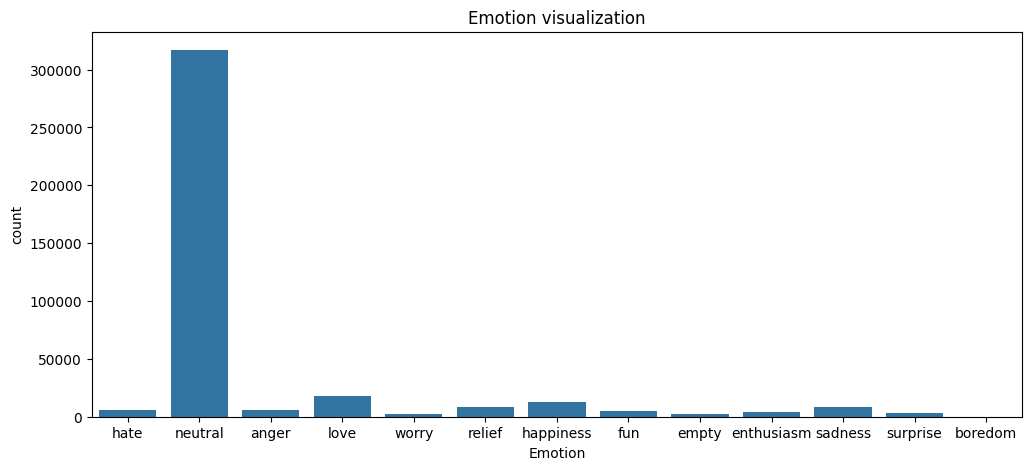

In [19]:
plt.figure(figsize=(12, 5))
sns.countplot(data = df, x = df['Emotion'])
plt.title("Emotion visualization")

In [123]:
def clean_text(text):
    '''
    Function to apply text cleaning using neattext
    '''
    docs = nt.TextFrame(text = text)
    docs.remove_puncts()
    docs.remove_stopwords()
    docs.remove_html_tags()
    docs.remove_special_characters()
    docs.remove_emojis()
    docs.fix_contractions()
    return docs.text

def lemmatization(text):
    '''
    Function to apply lemmatization to the current text
    '''
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

In [21]:
df.head()

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


In [22]:
df['clean_text'] = df['text'].apply(clean_text)

In [23]:
df.head()

,text,Emotion,clean_text
0,i seriously hate one subject to death but now ...,hate,seriously hate subject death feel reluctant drop
1,im so full of life i feel appalled,neutral,im life feel appalled
2,i sit here to write i start to dig out my feel...,neutral,sit write start dig feelings think afraid acce...
3,ive been really angry with r and i feel like a...,anger,ive angry r feel like idiot trusting place
4,i feel suspicious if there is no one outside l...,neutral,feel suspicious outside like rapture happened


In [24]:
df['clean_text'] = df['clean_text'].apply(lemmatization)

In [25]:
df.head()

,text,Emotion,clean_text
0,i seriously hate one subject to death but now ...,hate,seriously hate subject death feel reluctant drop
1,im so full of life i feel appalled,neutral,im life feel appalled
2,i sit here to write i start to dig out my feel...,neutral,sit write start dig feeling think afraid accep...
3,ive been really angry with r and i feel like a...,anger,ive angry r feel like idiot trusting place
4,i feel suspicious if there is no one outside l...,neutral,feel suspicious outside like rapture happened


In [26]:
X = df['clean_text']
Y = df['Emotion']

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [28]:
X_train.shape, X_test.shape

((315057,), (78765,))

In [38]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

## Model Selection & Training 

In [43]:
# decision tree
dt_model = DecisionTreeClassifier(random_state = 2)
dt_model.fit(X_train_vect, Y_train)

DecisionTreeClassifier(random_state=2)

In [44]:
y_pred = dt_model.predict(X_test_vect)

In [45]:
dt_accuracy = accuracy_score(Y_test, y_pred)

In [46]:
dt_accuracy

0.9836856471783152

In [47]:
rf_model = RandomForestClassifier(random_state = 2, n_jobs = -1)
rf_model.fit(X_train_vect, Y_train)

RandomForestClassifier(n_jobs=-1, random_state=2)

In [48]:
y_pred = rf_model.predict(X_test_vect)

## Model Evaluation

In [49]:
rf_accuracy = accuracy_score(Y_test, y_pred)

In [124]:
print("Accuracy on test data : ",rf_accuracy)

Accuracy on test data :  0.9872913095918238


In [51]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.97      0.99      0.98      1286
     boredom       1.00      0.75      0.86        12
       empty       0.96      0.35      0.51       571
  enthusiasm       1.00      0.98      0.99       900
         fun       0.98      0.96      0.97      1009
   happiness       0.98      0.99      0.98      2550
        hate       0.98      0.80      0.88      1223
        love       0.99      0.99      0.99      3566
     neutral       0.99      1.00      0.99     63261
      relief       0.98      0.92      0.95      1614
     sadness       0.99      0.98      0.99      1620
    surprise       0.99      0.96      0.97       711
       worry       0.94      0.95      0.94       442

    accuracy                           0.99     78765
   macro avg       0.98      0.89      0.92     78765
weighted avg       0.99      0.99      0.99     78765



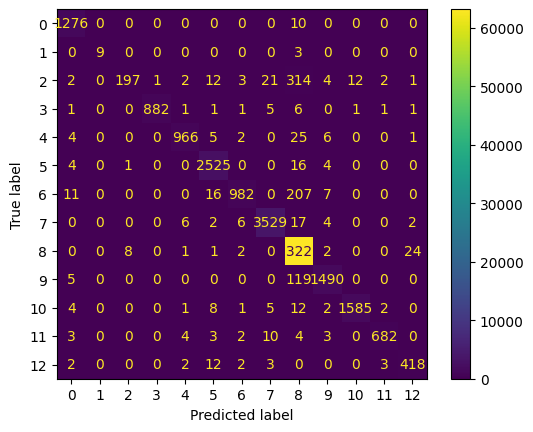

In [89]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [73]:
new_text = df['text'][10589]

In [74]:
new_text = clean_text(new_text)

In [77]:
new_text = [lemmatization(new_text)]

In [78]:
new_text

['opportunity express feeling beloved emotion arose']

In [79]:
new_text = vectorizer.transform(new_text)

In [119]:
rf_model.predict(new_text)[0]

'love'

In [84]:
cm = confusion_matrix(Y_test, y_pred)

In [90]:
y_pred_train = rf_model.predict(X_train_vect)

In [92]:
rf_accuracy_train = accuracy_score(Y_train, y_pred_train)

In [125]:
print("Accuracy on training data : ",rf_accuracy_train)

Accuracy on training data :  0.9994381968977042


## Model Deployment

In [83]:
import joblib

In [94]:
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']

In [127]:
joblib.dump(rf_model, "rf_model_comp.pkl", compress = 3, protocol = 4)

['rf_model_comp.pkl']

In [111]:
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']